# ESTUDIOS DE CORRELACIÓN

Permite llevar un registro de activos correlacionados (más y menos). Útil para ayudar a armar portafolios de inversión y administrar el riesgo.

## INDICE DE FUNCIONES:
- getCorr(activos, años): Esta función devuelve un dataframe con las correlaciones de los activos pasados como lista y un gráfico de calor para una mejor visualización.
- getCorrRank(activos, activo, años): Esta función devuelve una serie ordenada de los activos más correlacionados a menos correlacionados del activo en cuestión.
- clusterizar_dend(tickers, años): Es una función para graficar mapas de correlación a través de dendogramas, clusterizando tickers, agrupando los más correlacionados primero.
- getPeers(symbol): Función útil para encontrar acciones similares a una acción (correlacionadas), para mercados que no conocemos bien, etc.

In [3]:
# FUNCIONES PARA OBTENER INFORMACIÓN FINANCIERA

import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time

def getDataYf(ticker, tipo, interval, data_from = None, data_to = None, period = None):
    """
    Es una función para descargar market data de Yahoo Finance con la librería yfinance.
    
    ## Inputs:
        >ticker: el nombre del ticker.
        >tipo: si es "no end" no se indica hasta cuándo (data_to), se obtiene hasta el último día disponible. Si es "end" es
        necesario indicar hasta cuánto (data_to). En ambos casos hay que indicar desde qué fecha (data_from). Si es "period" 
        no se indica ni desde cuándo ni hasta cuándo, sólo el argumento "period" con la cantidad de tiempo a obtener.
        >now : si es True, no se indica hasta cuándo (data_to), se obtiene hasta el último día disponible. Si se indica False, es
        necesario indicar hasta cuánto (data_to).
        >interval: el timeframe (ej. 1mo, 1h, 1d, 1wk, etc)
        >data_from: data desde qué fecha.
        >data_to: data hasta qué fecha (no inclusive el día). Sólo es aplicable si now == True.
        >period : en caso de tipo = "period", se pasa este argumento que refiere a la cantidad de tiempo a obtener. Ej. 1y, 2y, 3y, etc.
        
    ## Outputs:
        >series OHLC ajustadas del ticker.
    """
    import yfinance as yf
    import pandas as pd
    
    if tipo == "no end":
        data = yf.download(ticker, start = data_from, interval = interval, progress = False, auto_adjust = True)
    elif tipo == "end":
        data = yf.download(ticker, start = data_from, end = data_to, interval = interval, progress = False, auto_adjust = True)
    elif tipo == "period":
        data = yf.download(ticker, interval = interval, period = period, progress = False, auto_adjust = True)
    return data



def getDataYfMulti(activos, tipo, interval, data_from = None, data_to = None, period = None, swap = True):
    """
    Función para hacer batch requests (varios tickers a la vez), que será la fx que más voy a utilizar para market data.
    
    ## Inputs:
        >tickers: es una lista con los tickers de los cuales se va a obtener market data.
        >tipo: si es "no end" no se indica hasta cuándo (data_to), se obtiene hasta el último día disponible. Si es "end" es
        necesario indicar hasta cuánto (data_to). En ambos casos hay que indicar desde qué fecha (data_from). Si es "period" 
        no se indica ni desde cuándo ni hasta cuándo, sólo el argumento "period" con la cantidad de tiempo a obtener.
        >now : si es True, no se indica hasta cuándo (data_to), se obtiene hasta el último día disponible. Si se indica False, es
        necesario indicar hasta cuánto (data_to).
        >interval: el timeframe (ej. 1mo, 1h, 1d, 1wk, etc)
        >data_from: data desde qué fecha.
        >data_to: data hasta qué fecha (no inclusive el día). Sólo es aplicable si now == True.
        >period : en caso de tipo = "period", se pasa este argumento que refiere a la cantidad de tiempo a obtener. Ej. 1y, 2y, 3y, etc.
        >swap : si es True, divide el df en tickers y cada uno tiene su OHLC. Si es False, tenemos cada columna OHLC y dentro todos los tickers.
        
    ## Outputs:
        >series OHLC ajustadas del ticker.
    """
    import yfinance as yf
    import pandas as pd
    
    lideres_arg = ["ALUA.BA", "BBAR.BA", "BMA.BA", "BYMA.BA", "CEPU.BA", "COME.BA", "CRES.BA", "CVH.BA", "EDN.BA", 
                   "GGAL.BA", "LOMA.BA", "MIRG.BA", "PAMP.BA", "SUPV.BA", "TECO2.BA", "TGNO4.BA", "TGSU2.BA", "TRAN.BA", 
                   "TXAR.BA", "VALO.BA", "YPFD.BA"]

    general_arg = ["AGRO.BA", "AUSO.BA", "BHIP.BA", "BOLT.BA", "BPAT.BA", "CADO.BA", "CAPX.BA", "CARC.BA", "CECO2.BA", 
                   "CELU.BA", "CGPA2.BA", "CTIO.BA", "DGCU2.BA", "FERR.BA", "FIPL.BA", "GAMI.BA", "GCDI.BA", "GCLA.BA", 
                   "HARG.BA", "HAVA.BA", "INVJ.BA", "IRSA.BA", "LEDE.BA", "LONG.BA", "METR.BA", "MOLA.BA", "MOLI.BA", 
                   "MORI.BA", "OEST.BA", "PATA.BA", "RICH.BA", "RIGO.BA", "SAMI.BA", "SEMI.BA"]

    cedears = ["AAL", "AAPL", "ABBV", "ABEV", "ABNB", "ABT", "ADBE", "ADGO", "ADI", "ADP", "AEM", "AIG", "AMAT", "AMD", 
               "AMGN", "AMZN", "AOCA", "ARCO", "ARKK", "ASR", "AUY", "AVGO", "AXP", "AZN", "BA", "BA.C", "BABA", "BB", 
               "BBD", "BBV", "BCS", "BHP", "BIDU", "BIIB", "BIOX", "BITF", "BK", "BMY", "BNG", "BP", "BRFS", "BRKB", "BSBR", 
               "C", "CAAP", "CAH", "CAR", "CAT", "CBRD", "CDE", "CL", "COIN", "COST", "CRM", "CS", "CSCO", "CVX", "CX", "DD", 
               "DE", "DESP", "DIA", "DISN", "DOCU", "DOW", "E", "EA", "EBAY", "EEM", "EFX", "ERIC", "ERJ", "ETSY", "EWZ", "F", 
               "FCX", "FDX", "FMX", "FSLR", "GE", "GFI", "GGB", "GILD", "GLOB", "GLW", "GM", "GOLD", "GOOGL", "GPRK", "GRMN", 
               "GS", "HAL", "HD", "HL", "HMC", "HMY", "HOG", "HON", "HPQ", "HSBC", "HSY", "HUT", "HWM", "IBM", "IFF", "INTC", 
               "ITUB", "IWM", "JD", "JMIA", "JNJ", "JPM", "KMB", "KO", "KOFM", "LLY", "LMT", "LRCX", "LVS", "LYG", "MA", "MCD", 
               "MDT", "MELI", "META", "MMM", "MO", "MOS", "MRK", "MSFT", "MSI", "MSTR", "MU", "NEM", "NFLX", "NGG", "NIO", "NKE", 
               "NOKA", "NTCO", "NTES", "NUE", "NVDA", "NVS", "ORAN", "ORCL", "OXY", "PAAS", "PAC", "PANW", "PBI", "PBR", "PCAR", 
               "PEP", "PFE", "PG", "PHG", "PKS", "PSX", "PYPL", "QCOM", "QQQ", "RBLX", "RIO", "RTX", "SAN", "SAP", "SATL", "SBUX", 
               "SCCO", "SE", "SHEL", "SHOP", "SI", "SID", "SLB", "SNAP", "SNOW", "SONY", "SPGI", "SPOT", "SPY", "SQ", "SYY", "T", 
               "TEFO", "TEN", "TGT", "TM", "TMO", "TRIP", "TRVV", "TSLA", "TSM", "TTE", "TV", "TWLO", "TXN", "TXR", "UAL", "UBER", 
               "UGP", "UL", "UNH", "UNP", "UPST", "USB", "V", "VALE", "VIST", "VIV", "VOD", "VZ", "WBA", "WFC", "WMT", "X", "XLE", 
               "XLF", "XOM", "XP", "YY", "ZM"]

    adrs = ["BBAR", "BMA", "CEPU", "CRESY", "EDN", "GGAL", "IRS", "LOMA", "PAM", "SUPV", "TEO", "TGS", "TS", "TX", "YPF"]

    sectors = ["XLC", "XLP", "XLY", "XLF", "XLV", "XLI", "XLRE", "XLU", "XBI", "XLB", "XLK", "XLE"]
    
    precarga = ["lideres", "general", "cedears", "adrs", "sectores"]
    precarga_dict = {"lideres" : lideres_arg, "general" : general_arg, "cedears" : cedears, "adrs" : adrs, "sectores" : sectors}
    
    if activos in precarga:
        activos = precarga_dict[activos]
    
    if tipo == "no end":
        data = yf.download(activos, start = data_from, interval = interval, progress = False, auto_adjust = True)
    elif tipo == "end":
        data = yf.download(activos, start = data_from, end = data_to, interval = interval, progress = False, auto_adjust = True)
    elif tipo == "period":
        data = yf.download(activos, interval = interval, period= period, progress = False, auto_adjust = True)
    
    if swap:
        #data = data.swaplevel(i = 0, j = 1, axis = 1)
        # Algoritmo para procesar el MultipleTicker download de yfinance
        dicto = {}
        low = data["Low"]
        high = data["High"]
        close = data["Close"]
        open = data["Open"]
        volume = data["Volume"]

        tickers = list(data["Close"].columns)

        for ticker in tickers:
            dicto[ticker] = {
                "Open" : open[ticker],
                "High" : high[ticker],
                "Low" : low[ticker],
                "Close" : close[ticker],
                "Volume" : volume[ticker]
            }

            dicto[ticker] = pd.DataFrame(dicto[ticker])
        return dicto
    return data


In [5]:
# FUNCIONALIDADES PRINCIPALES:

def getCorr(activos, años):
    """
    Esta función devuelve un dataframe con las correlaciones de los activos pasados como lista y un gráfico de calor para una mejor visualización.
    
    # Inputs:
        - activos: lista de activos a evaluar correlación.
        - años: cantidad de años hacia atrás de data financiera para obtener precios, calcular variaciones y evaluar correlación.
    
    # Outputs:
        - tabla de correlaciones: un dataframe con las correlaciones de los activos pasados como lista.
        - gráfico heatmap: graficando las correlaciones de los activos pasados como lista.
        - estilado: tabla de correlaciones con formato condicional.
    """
    
    import yfinance as yf
    import pandas as pd
    import numpy as np
    from datetime import datetime, timedelta
    import time

    # Obtener data
    data = getDataYfMulti(activos, tipo = "period", interval = "1d", period = f"{años}y", swap = False)["Close"]
    
    # Calcular correlaciones
    changes = data.pct_change()
    corr = changes.corr().round(2)
    
    # Graficar correlaciones
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize=(12, 8))
    plt.matshow(corr, fignum=fig.number, cmap="YlGn")
    plt.xticks(range(corr.shape[1]), corr.columns, fontsize=12, rotation=90)
    plt.yticks(range(corr.shape[1]), corr.columns, fontsize=12)

    cb = plt.colorbar(orientation="vertical", label="Factor de Correlación r")
    cb.ax.tick_params(labelsize=12)
    plt.title("MATRIZ DE CORRELACIÓN", fontsize=16, y=1.15)

    ax = plt.gca()
    ax.set_xticks(np.arange(-.5, 9, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 9, 1), minor=True)
    ax.grid(which="minor", color="white", linestyle="-", linewidth=3)

    for i in range(corr.shape[0]):
        for j in range(corr.shape[1]):
            if corr.iloc[i, j] > 0.6:
                color = "white"
            else:
                color = "black"
            fig.gca().text(i, j, "{:.2f}".format(corr.iloc[i, j]), ha="center", c=color, va="center", size="11")
    plt.close()
    estilado = corr.style.background_gradient(cmap="Blues").format('{:.2f}')
    
    return corr, fig, estilado


def getCorrRank(activos, activo, años):
    """
    Esta función devuelve una serie ordenada de los activos más correlacionados a menos correlacionados del activo en cuestión.
    
    # Inputs:
        - activos: lista de activos a evaluar correlación.
        - activo: activo del cual se desea analizar correlacionados.
        - años: cantidad de años hacia atrás de data financiera para obtener precios, calcular variaciones y evaluar correlación.
    
    # Outputs:
        - data: una serie ordenada de los activos más correlacionados a menos correlacionados del activo en cuestión.
        - estilado: ranking con formato condicional.
    """
    
    import yfinance as yf
    import pandas as pd
    import numpy as np
    from datetime import datetime, timedelta
    import time
    
    # Obtener data
    data = getDataYfMulti(activos, tipo = "period", interval = "1d", period = f"{años}y", swap = False)["Close"]
    
    # Calcular correlaciones
    changes = data.pct_change()
    corr = changes.corr().round(2)
    
    data = corr[activo].sort_values(ascending = False)
    data = data[data != 1]
    data = pd.DataFrame(data)
    estilado = data.style.background_gradient(cmap="Blues").format('{:.2f}')
    return data, estilado


def clusterizar_dend(tickers, años):
    """
    Es una función para graficar mapas de correlación a través de dendogramas, clusterizando tickers, agrupando los más correlacionados
    primero. 
    # Inputs:
        - tickers: lista de activos (tickers).
        - años: años hacia atrás desde el día de la fecha, para la consulta de market data.
    # Outputs:
        - gráfico de clusterización con dendogramas.
    """
    
    # Seaborn: CLUSTERS CON DENDOGRAMAS
    # Otra forma de realizar mapas de correlación, la más prolija respecto a correlación de
    # rendimientos, es a través de CORRELACIÓN DE RENDIMIENTOS POR CLUSTERS. Es decir, el gráfico
    # sólo se encarga de agrupar los activos más parecidos en la zona del gráfico para que la
    # lectura sea más práctica y eficiente.
    # Para hacerlo, seaborn se apoya en un método de clusterización jerárquico de scipy, que
    # también usa sklearn. Lo que hace el método en definitva es ir agrupando cada activo con
    # los que mejor correlaciona, y en cada iteración busca pivotear con el de mayor match, y
    # así hasta que termina uniendo hasta los que no correlacionan con nada.

    import pandas as pd
    import seaborn as sns
    import yfinance as yf
    import matplotlib.pyplot as plt

    data = getDataYfMulti(tickers, tipo = "period", interval = "1d", period = f"{años}y", swap = False)["Close"].pct_change().dropna()

    # Graficamos:
    return  sns.clustermap(data.corr(), cmap="Blues", dendrogram_ratio = (.1, .3), 
                   cbar_pos = (1.05, 0.10,.02, 0.6),
                   linewidths = 1, figsize=(10,10))


def getPeers(symbol):
    """
    Función útil para encontrar acciones similares a una acción (correlacionadas), para mercados que no conocemos bien, etc.
    # Inputs:
        - symbol: el ticker.
    # Outputs:
        - activos similares (por correlación) al buscado.
    """
    
    import requests
    import json
    
    TOKEN = "XXXXXXXXXXX"
    url = "https://finnhub.io/api/v1/stock/peers"
    p = {"token" : TOKEN, "symbol" : symbol}
    r = requests.get(url, params = p)
    js = r.json()
    #df = pd.DataFrame(js)
    return js

In [10]:
data, graf, data_est = getCorr(activos = "adrs", años = 15)

In [11]:
# getCorr output data_est
data_est

,BBAR,BMA,CEPU,CRESY,EDN,GGAL,IRS,LOMA,PAM,SUPV,TEO,TGS,TS,TX,YPF
BBAR,1.00,0.78,0.70,0.49,0.51,0.79,0.44,0.67,0.65,0.80,0.54,0.51,0.35,0.33,0.54
BMA,0.78,1.00,0.69,0.50,0.51,0.81,0.46,0.67,0.65,0.79,0.56,0.54,0.34,0.32,0.55
CEPU,0.70,0.69,1.00,0.55,0.58,0.71,0.51,0.64,0.72,0.67,0.55,0.70,0.28,0.32,0.62
CRESY,0.49,0.50,0.55,1.00,0.38,0.50,0.54,0.51,0.49,0.53,0.43,0.44,0.33,0.31,0.42
EDN,0.51,0.51,0.58,0.38,1.00,0.51,0.37,0.53,0.56,0.60,0.39,0.43,0.22,0.20,0.38
GGAL,0.79,0.81,0.71,0.50,0.51,1.00,0.46,0.68,0.66,0.82,0.55,0.53,0.34,0.32,0.54
IRS,0.44,0.46,0.51,0.54,0.37,0.46,1.00,0.47,0.45,0.51,0.39,0.40,0.27,0.24,0.34
LOMA,0.67,0.67,0.64,0.51,0.53,0.68,0.47,1.00,0.65,0.65,0.52,0.63,0.27,0.38,0.57
PAM,0.65,0.65,0.72,0.49,0.56,0.66,0.45,0.65,1.00,0.68,0.49,0.62,0.28,0.30,0.52
SUPV,0.80,0.79,0.67,0.53,0.60,0.82,0.51,0.65,0.68,1.00,0.52,0.66,0.29,0.31,0.62


In [ ]:
# getCorr output data
data

,BBAR,BMA,CEPU,CRESY,EDN,GGAL,IRS,LOMA,PAM,SUPV,TEO,TGS,TS,TX,YPF
BBAR,1.00,0.78,0.70,0.49,0.51,0.79,0.44,0.67,0.65,0.80,0.54,0.51,0.35,0.33,0.54
BMA,0.78,1.00,0.69,0.50,0.51,0.81,0.46,0.67,0.65,0.79,0.56,0.54,0.34,0.32,0.55
CEPU,0.70,0.69,1.00,0.55,0.58,0.71,0.51,0.64,0.72,0.67,0.55,0.70,0.28,0.32,0.62
CRESY,0.49,0.50,0.55,1.00,0.38,0.50,0.54,0.51,0.49,0.53,0.43,0.44,0.33,0.31,0.42
EDN,0.51,0.51,0.58,0.38,1.00,0.51,0.37,0.53,0.56,0.60,0.39,0.43,0.22,0.20,0.38
GGAL,0.79,0.81,0.71,0.50,0.51,1.00,0.46,0.68,0.66,0.82,0.55,0.53,0.34,0.32,0.54
IRS,0.44,0.46,0.51,0.54,0.37,0.46,1.00,0.47,0.45,0.51,0.39,0.40,0.27,0.24,0.34
LOMA,0.67,0.67,0.64,0.51,0.53,0.68,0.47,1.00,0.65,0.65,0.52,0.63,0.27,0.38,0.57
PAM,0.65,0.65,0.72,0.49,0.56,0.66,0.45,0.65,1.00,0.68,0.49,0.62,0.28,0.30,0.52
SUPV,0.80,0.79,0.67,0.53,0.60,0.82,0.51,0.65,0.68,1.00,0.52,0.66,0.29,0.31,0.62


In [14]:
# analyze one asset
data["TGS"].sort_values(ascending = False)

TGS      1.00
CEPU     0.70
SUPV     0.66
LOMA     0.63
PAM      0.62
BMA      0.54
GGAL     0.53
BBAR     0.51
YPF      0.47
CRESY    0.44
EDN      0.43
TEO      0.43
IRS      0.40
TS       0.27
TX       0.25
Name: TGS, dtype: float64

In [15]:
data, data_est = getCorrRank(activos = ["BBAR", "GGAL", "CEPU", "CRESY", 
                                        "PAM", "YPF", "TS", "TGS", "LOMA", 
                                        "EDN", "TSLA", "FERR.BA", "LONG.BA", "SUPV"], 
                             activo = "GGAL", años = 15)

In [16]:
# getCorrRank data_est output
data_est

,GGAL
SUPV,0.82
BBAR,0.79
CEPU,0.71
LOMA,0.68
PAM,0.66
YPF,0.54
TGS,0.53
EDN,0.51
CRESY,0.50
TS,0.34


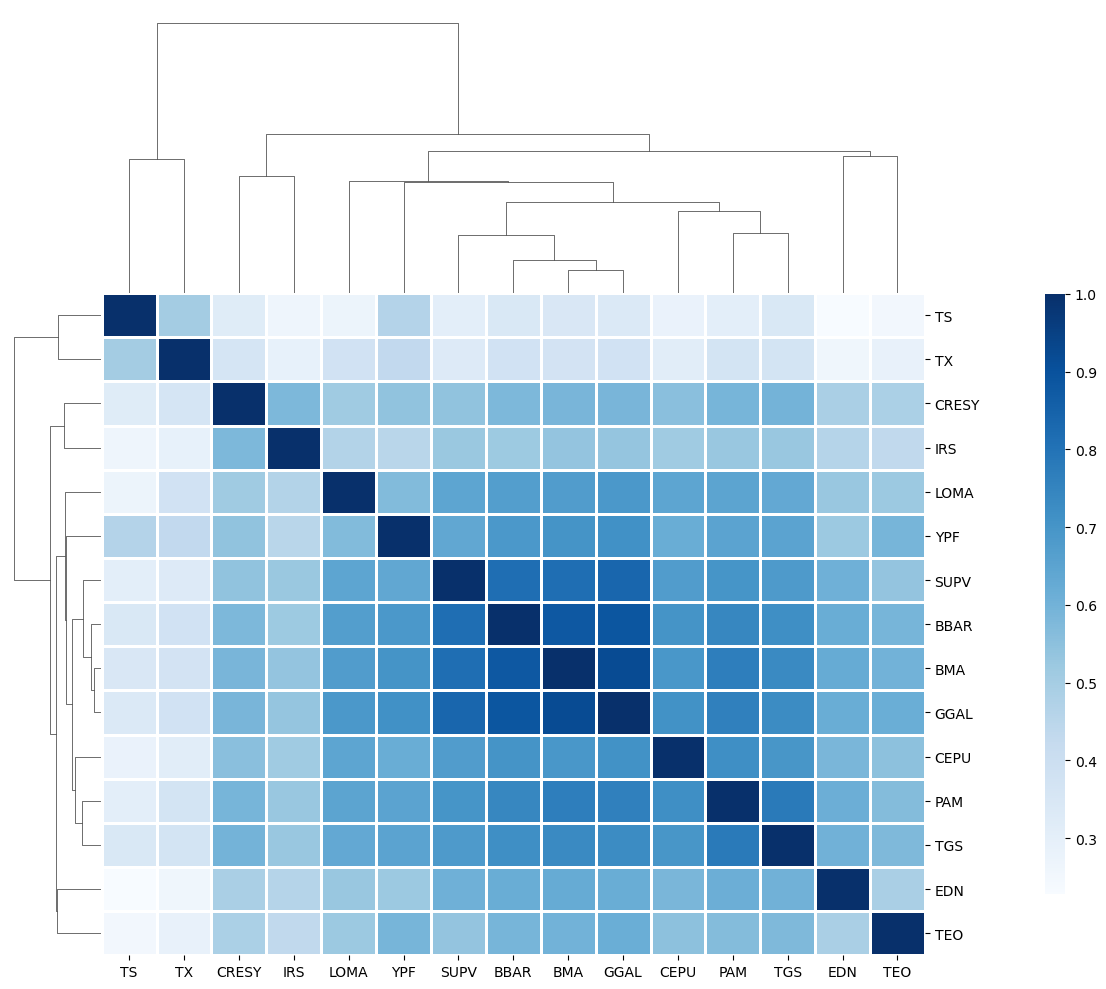

In [17]:
clusterizar_dend(tickers = "adrs", años = 15)

In [18]:
data = getPeers("GGAL")
data

['GGAL3.BA',
 'BMA3.BA',
 'BBAR3.BA',
 'BPAT3.BA',
 'SUPV3.BA',
 'BRIO3.BA',
 'BHIP3.BA']

In [6]:
# MOSTRAR UNA TABLA DE CORRELACIONES ENTRE LOS ADRS:

tabla = pd.read_excel("C:\\Users\\user\\anaconda3\\Scripts\\python-quant\\ADRs_varRel.xlsx")
tabla.set_index("timestamp", inplace=True)

correlaciones = tabla.corr().round(2)
correlaciones

,BBAR,BMA,CRESY,EDN,GGAL,PAM,TEO,TGS,YPF
BBAR,1.00,0.79,0.50,0.53,0.81,0.65,0.57,0.52,0.51
BMA,0.79,1.00,0.51,0.52,0.81,0.64,0.57,0.53,0.52
CRESY,0.50,0.51,1.00,0.40,0.51,0.47,0.44,0.42,0.41
EDN,0.53,0.52,0.40,1.00,0.53,0.60,0.41,0.44,0.40
GGAL,0.81,0.81,0.51,0.53,1.00,0.65,0.57,0.53,0.54
PAM,0.65,0.64,0.47,0.60,0.65,1.00,0.48,0.58,0.48
TEO,0.57,0.57,0.44,0.41,0.57,0.48,1.00,0.40,0.44
TGS,0.52,0.53,0.42,0.44,0.53,0.58,0.40,1.00,0.46
YPF,0.51,0.52,0.41,0.40,0.54,0.48,0.44,0.46,1.00


In [ ]:
# MOSTRAR PARA, CADA ACTIVO, SU PAR MENOS CORRELACIONADO:
tabla = pd.read_excel("ADRs_historial.xlsx")
tabla.set_index("timestamp", inplace=True)

correlaciones = tabla.corr().round(2)
correlaciones.idxmin()

In [ ]:
# MOSTRAR PARA, CADA ACTIVO, SU PAR MÁS CORRELACIONADO (excepto sí mismo):
tabla = pd.read_excel("ADRs_historial.xlsx")
tabla.set_index("timestamp", inplace=True)

# Calculamos correlaciones:
correlaciones = tabla.corr().round(2)
# Eliminamos las correlaciones = 1 (consigo mismo):
correlaciones.replace(1, 0, inplace=True)
# Y obtenemos las máx correlaciones/par más correlacionado:
correlaciones.idxmin()

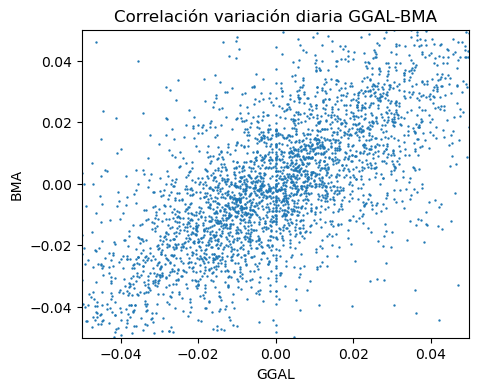

In [40]:
# GRÁFICO SCATTERPLOT PERSONALIZADO PARA VISUALIZAR MEJOR
# Claves: aplicar los puntos con "marker="."" y aplicar escala a ejes X e Y para hacer zoom y ver mejor (set_xlim y set_ylim)
# Puedo acortar el x e y lim a 5 para hacer máz zoom aún, etc. Voy graduando. Y con el marker="." y s=2 achico los puntos para ver mejor.

import matplotlib.pyplot as plt

# Obtener data
data = getDataYfMulti(["GGAL", "BMA"], tipo = "period", interval = "1d", period = f"{años}y", swap = False)["Close"]
    
# Calcular correlaciones
changes = data.pct_change()

fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(changes["GGAL"], changes["BMA"], marker=".", s=2)
ax.set_xlim((-0.05, 0.05))
ax.set_ylim((-0.05, 0.05))
ax.set_xlabel("GGAL")
ax.set_ylabel("BMA")
ax.set_title("Correlación variación diaria GGAL-BMA")
plt.show()

In [ ]:
# GRÁFICOS HEATMAPS (MAPAS DE CALOR)
# Se puede usar para ilustrar correlaciones (una matriz de varios activos)

# 1° Armar el DF de variaciones:

activos = ["BBAR", "BMA", "CRESY", "EDN", "GGAL", "PAM", "TEO", "TGS", "YPF"]

listaVariaciones = []
for activo in activos:
    tabla = pd.read_excel(f"datasets\\ADRs\\{activo}.xlsx")
    tabla = tabla.sort_values("timestamp", ascending=True)
    tabla["change_pct"] = tabla["adjusted_close"].pct_change()*100
    tabla.set_index("timestamp", inplace=True)
    listaVariaciones.append(tabla["change_pct"])

tablaFinal = pd.concat(listaVariaciones, axis=1)
tablaFinal.columns = activos

# 2° Armar DF con las correlaciones:

df = tablaFinal.corr().round(2)

# 3° Grafico con la fx personalizada de JPP (pasar a función!!!): (p.155 t2)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
plt.matshow(df, fignum=fig.number, cmap="YlGn")
plt.xticks(range(df.shape[1]), df.columns, fontsize=12, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=12)

cb = plt.colorbar(orientation="vertical", label="Factor de Correlación r")
cb.ax.tick_params(labelsize=12)
plt.title("MATRIZ DE CORRELACIÓN DE ADRs", fontsize=16, y=1.15)

ax = plt.gca()
ax.set_xticks(np.arange(-.5, 9, 1), minor=True)
ax.set_yticks(np.arange(-.5, 9, 1), minor=True)
ax.grid(which="minor", color="white", linestyle="-", linewidth=3)

for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        if df.iloc[i, j] > 0.6:
            color = "white"
        else:
            color = "black"
        fig.gca().text(i, j, "{:.2f}".format(df.iloc[i, j]), ha="center", c=color, va="center", size="14")
plt.show()

In [ ]:
# MATRICES DE CORRELACIÓN ENTRE RENDIMIENTOS DE ACTIVOS SEGREGANDO POR PERÍODOS: armar un DataFrame con los promedios de las correlaciones de los 4 períodos del ejercicio anterior.# SOLUCIÓN EJ N° 7: Armar una grilla con 4 subplots. Cada uno de ellos deberá tener la matriz de correlación de los ADRs argentinos que tengan cotizaciones desde 2010 al menos.
# Las 4 matrices deberán tener las correlaciones para los siguientes períodos de tiempo: 1) hasta el 31/12/2011; 2) desde 01/01/2012 al 31/12/2014; 3) del 01/01/2015 al 31/12/2017
# y 4) del 01/01/2018 al 31/12/2020. Configurar las matrices a gusto.

import math
import pandas as pd
import matplotlib.pyplot as plt

tickers = ["BBAR", "BMA", "CRESY", "EDN", "GGAL", "PAM", "TEO", "TGS", "YPF"]
listaVariaciones = []
for ticker in tickers:
    df = pd.read_excel(f"datasets\\ADRs\\{ticker}.xlsx")
    df = df.sort_values(by="timestamp", ascending=True)
    df["pct_change"] = df["adjusted_close"].pct_change()*100
    df.set_index("timestamp", inplace=True)
    listaVariaciones.append(df["pct_change"])
    
ADRs = pd.concat(listaVariaciones, axis=1).dropna()
ADRs.columns = tickers

data = {}
data[0] = ADRs.loc[ADRs.index < "2012"].corr()
data[1] = ADRs.loc[(ADRs.index >= "2012") & (ADRs.index < "2015")].corr()
data[2] = ADRs.loc[(ADRs.index >= "2015") & (ADRs.index < "2018")].corr()
data[3] = ADRs.loc[(ADRs.index >= "2018")].corr()

txt=["2009-2010-2011", "2012-2013-2014", "2015-2016-2017", "2018-2019-2020"]

fig, ax = plt.subplots(figsize=(14, 16), nrows=2, ncols=2)

for n in range(4):
    fila = math.floor(n/2)
    col = n%2
    
    ax[fila][col].matshow(data[n], cmap="Greens")
    ax[fila][col].set_title("Matriz Correlación ADRs - " + txt[n], fontsize=16)
    ax[fila][col].set_xticks(np.arange(0, 9, 1), minor=False)
    ax[fila][col].set_yticks(np.arange(0, 9, 1), minor=False)
    ax[fila][col].set_xticklabels(data[n].columns, rotation=90, minor=False)
    ax[fila][col].set_yticklabels(data[n].columns, fontsize=12)
    
    for i in range(data[n].shape[1]):
        for j in range(data[n].shape[1]):
            if data[n].iloc[i, j] > 0.7:
                color = "white"
            else:
                color = "black"
            
            ax[fila][col].text(i, j, "{:.2f}".format(data[n].iloc[i,j]), ha="center", va="center", c=color, size=14)
plt.show()

In [ ]:
# CALCULAR PROMEDIOS DE CORRELACIONES POR PERÍODOS: armar un DataFrame con los promedios de las correlaciones de los 4 períodos del ejercicio anterior.

fig, ax = plt.subplots(figsize=(8,5))

medias = pd.DataFrame()
for i in range(4):
    media = round(data[i].mean().mean(), 2)
    medias.loc[i, "Corr Media"] = media
    plt.annotate(media, xy = [i-0.15, media-0.05], color="white", fontsize=14)

medias["años"] = txt
medias.set_index("años", inplace=True)

plt.bar(medias.index, medias["Corr Media"], width=0.5)
ax.set_title("CORRELACIONES PROMEDIO ADRs, POR PERÍODOS")
medias

In [ ]:
# Seaborn: Scatter múltiples + Regresiones
# Si bien ya lo vimos, a veces necesitamos con pocas líneas de código ver un scatter típico de correlación pero de varios activos
# a la vez y visualiazr también las rectas de regresión.

# Ejemplo: correlación sigma rápido (40 días) y sigma lento (200 días), queremos ver cómo correlacionan y sus rectas de regresión:
# Bajamos la data:

import yfinance as yf
import pandas as pd

fast, slow = 40, 200
tickers = ["GGAL", "BMA", "BBAR", "SPXS", "TSLA", "SQQQ"]
data = yf.download(tickers, auto_adjust = True, start = "2010-01-01")
data = data["Close"].pct_change()*100
sigma_fast = (data.rolling(fast).std() * 250 ** 0.5).dropna().iloc[slow-fast:]
sigma_slow = (data.rolling(slow).std() * 250 ** 0.5).dropna()
df1 = sigma_fast.melt(var_name = "Ticker", value_name = "sigma_fast")
df2 = sigma_slow.melt(var_name = "Ticker", value_name = "sigma_slow")
df = pd.concat([df1, df2["sigma_slow"]], axis = 1)
pd.options.display.max_rows = 4
df

# Importamos seaborn, seteamos un tema y graficamos:
#(Temas disponibles: Darkgrid, Whitegrid, Dark, White, ticks)

import seaborn as sns
sns.set_theme(style="whitegrid")

plot = sns.lmplot(data = df, x = "sigma_fast", y = "sigma_slow", col = "Ticker", 
                  hue = "Ticker", col_wrap = 3, height = 4, fit_reg = True,
                  scatter_kws = {"s" : 1, "alpha" : 1})

titulo = f"Correlación de volatilidades históricas {fast}-{slow}"
plot.fig.suptitle(titulo, fontsize=16, y=1.02)

In [ ]:
# SEABORN: MAPAS DE CORRELACIÓN
import pandas as pd
import yfinance as yf

faang = ["META", "AMZN", "AAPL", "NFLX", "GOOGL"]
bcos_arg = ["BBAR", "GGAL", "BMA", "SUPV"]
etfs_bull = ["QQQ", "SPY", "EEM", "SLV", "XLF", "XLE", "HYG", "IWM", "EWZ", "GDX",
             "TLT", "SPTL"]
etfs_bear = ["SQQQ", "UVXY", "SPXS", "RWM", "DLBS", "SAGG", "DGZ", "REK", "CHAD"]

# Obtenemos la data:
tickers = faang + bcos_arg + etfs_bull + etfs_bear
data = yf.download(tickers, auto_adjust = True)["Close"].pct_change().dropna()
df = data.corr()

import seaborn as sns
sns.heatmap(df, cmap="binary", linewidths=1)

# Tiene infinidad de métodos: help(sns.heatmap)

<AxesSubplot:>

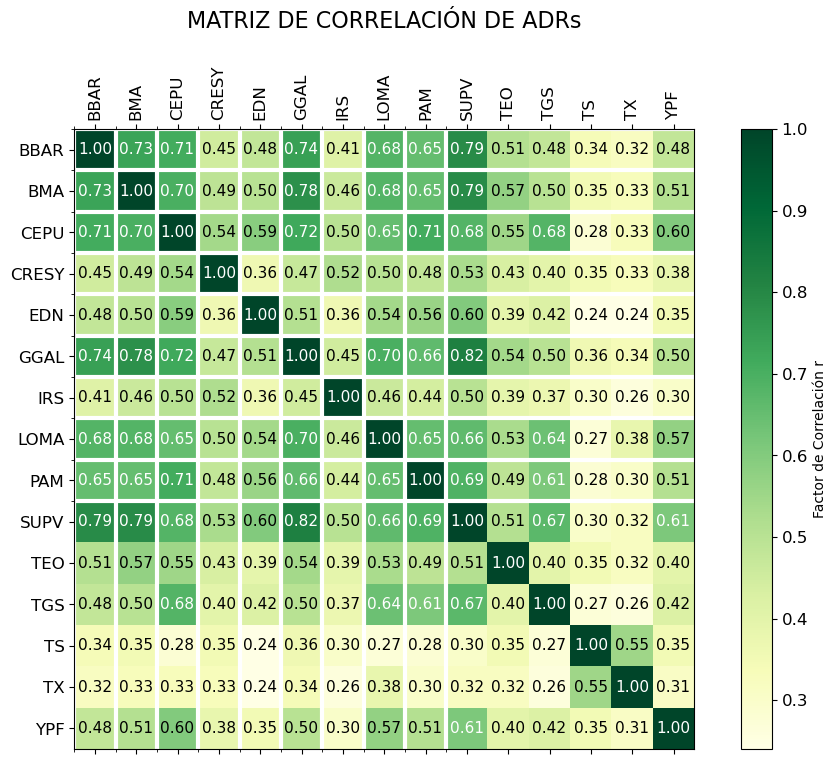

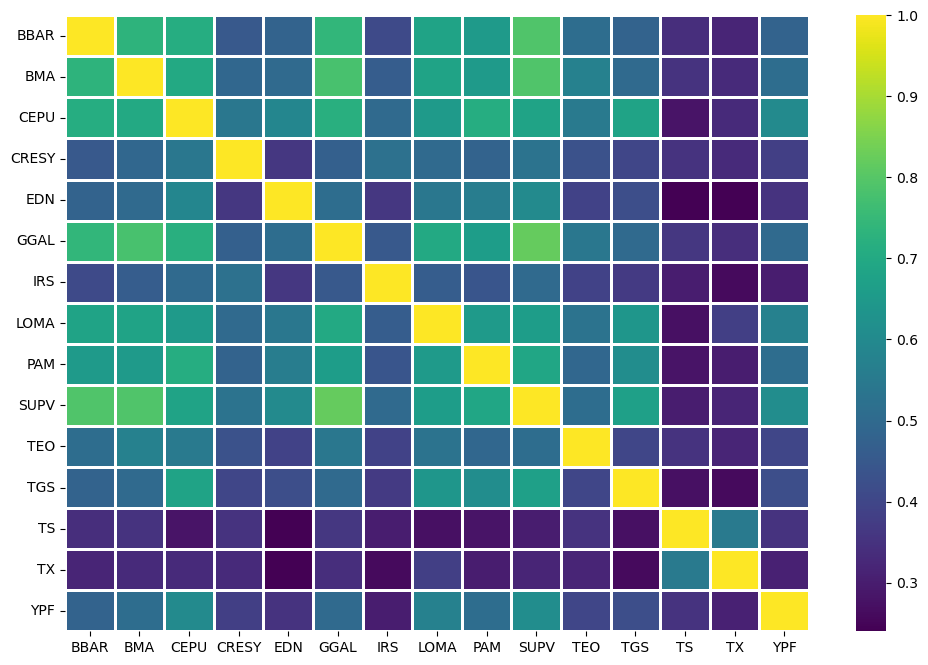

In [53]:
adrs = ["BBAR", "BMA", "CEPU", "CRESY", "EDN", "GGAL", "IRS", "LOMA", "PAM", "SUPV", "TEO", "TGS", "TS", "TX", "YPF"]
data, graf = getCorr(adrs, 15)
import seaborn as sns
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(data, cmap="viridis", linewidths=1, ax = ax)

In [ ]:
# Seaborn: CLUSTERS CON DENDOGRAMAS
# Otra forma de realizar mapas de correlación, la más prolija respecto a correlación de
# rendimientos, es a través de CORRELACIÓN DE RENDIMIENTOS POR CLUSTERS. Es decir, el gráfico
# sólo se encarga de agrupar los activos más parecidos en la zona del gráfico para que la
# lectura sea más práctica y eficiente.
# Para hacerlo, seaborn se apoya en un método de clusterización jerárquico de scipy, que
# también usa sklearn. Lo que hace el método en definitva es ir agrupando cada activo con
# los que mejor correlaciona, y en cada iteración busca pivotear con el de mayor match, y
# así hasta que termina uniendo hasta los que no correlacionan con nada.

# Bajamos la data:

import pandas as pd
import seaborn as sns
import yfinance as yf

tickers = ["BBAR", "GGAL", "YPF", "PAM", "TGS", "EDN", "TEO", "CRESY", "PBR", "ITUB",
           "AAPL", "META", "GOOGL", "AMZN", "KO", "JPM", "GE", "SPY", "QQQ", "EEM", "DJI"]

df = yf.download(tickers, auto_adjust = True)["Close"].pct_change().dropna()

# Graficamos:
sns.clustermap(df.corr(), cmap="Blues", dendrogram_ratio = (.1, .3), 
               cbar_pos = (1.05, 0.10,.02, 0.6),
               linewidths = 1, figsize=(10,10))
# Entonces fijate que arranca uniendo GGAL con BBAR, que son los que mejor correlacionan.
# Luego le agrega PAM, que es el que le sigue jerárquicamente, y así hasta que termina
# uniendo todo el nodo de ADRs.

In [ ]:
# EJERCICIOS ÚTILES: N° 5) P. 26
# SENSIBILIDAD DE LA CORRELACIÓN ENTRE EL RSI Y EL RENDIMIENTO DE LA RUEDA SIGUIENTE,
# SEGÚN LAS DISTINTAS CONFIGURACIONES N RUEDAS HACIA ÁTRAS DEL RSI, PARA VARIOS ACTIVOS,
# SEGMENTANDO POR ZONAS DE SV, SC Y ZM.
# Usando las funciones de los ejercicios anteriores, armar un script que recorra los 12 ADRs
# y grafique la sensibilidad del coeficiente de correlación RSI / Rendimiento sig rueda,
# pero segmentando según se encuentre en zona de sobreVenta, sobreCompra o neutral, y hacer
# cada gráfico en un recorrido de 2 a 40 ruedas de la configuración del RSI

tickers = ["BBAR", "BMA", "CEPU", "CRESY", "EDN", "GGAL", "LOMA", "PAM", "SUPV", "TEO",
         "TGS", "YPF"]
fig, ax = plt.subplots(figsize=(15,12), nrows=3, ncols=4)
n = 40

for i in range(len(tickers)):
    fila = math.floor(i/4)
    col = i%4
    ticker = tickers[i]
    x, rs = corrRSIsobreventa(ticker, maxRuedas = n, carpeta = "datasets\\ADRs", maxRSI=30)
    ax[fila][col].plot(x, rs, "r--", label = "SobreVenta")
    
    x, rs = corrRSIsobrecompra(ticker, maxRuedas = n, carpeta = "datasets\\ADRs", minRSI=70)
    ax[fila][col].plot(x, rs, "k-", label = "SobreCompra")
    
    x, rs = corrRSIzonamedia(ticker, maxRuedas = n, carpeta = "datasets\\ADRs", minRSI=30, maxRSI=70)
    ax[fila][col].plot(x, rs, "k-.", alpha=0.3, label="Neutral")
    ax[fila][col].set_ylim(-0.3, 0.3)
    ax[fila][col].legend(loc = "upper right", fontsize= 10)
    ax[fila][col].grid(which = "major")
    ax[fila][col].set_xlabel("N° Ruedas del RSI", color = "gray")
    ax[fila][col].set_ylabel("Valor absoluto Factor Corr r", c = "gray")
    ax[fila][col].set_title(tickers[i], y = 0.03, fontweight = "bold", alpha=0.3, fontsize=25, c="gray")
    
plt.suptitle("Coeficiente de Correlación entre RSI y el rendimiento de la rueda siguiente\
    En función del 'n' del RSI, para estados de SobreCompra y SobreVenta", y = 0.96)
    
plt.subplots_adjust(wspace = 0.45, hspace = 0.35)
plt.show()

In [ ]:
# CORRELACIÓN DE DOS VARIABLES (VOLATILIDAD 20r y AMPLITUD HIGH-LOW DIARIO): Graficar en un gráfico de dispersión la relación entre la volatilidad de las últimas 20 ruedas de AAPL y su rango porcentual de movimiento intradiario (low high).
# Usar percentiles para que las escalas estén de 0 a 1.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# PREPARACIÓN DATASET
data = pd.read_excel("datasets\\AAPL.xlsx")
data.set_index("timestamp", inplace=True)
data.sort_values(by="timestamp", inplace=True)

data["variacion"] = data["adjusted_close"].pct_change()*100
data["vol20"] = data["variacion"].rolling(20).std()
data["rangoIntra"] = ((data["high"] / data["low"])-1)*100

data["rankAMP"] = data["rangoIntra"].rank(pct=True)
data["rankVOL"] = data["vol20"].rank(pct=True)

x = data["rankAMP"]
y = data["rankVOL"]

# CÁLCULO DE LA RECTA DE REGRESIÓN:
b1 = x.cov(y) / x.var()
b0 = y.mean() - (b1 * x.mean())
recta = b0 + b1*x
# CÁLCULO DE R Y R2
r = round(x.corr(y),2)
r2 = round(x.corr(y)**2, 2)

# GRAFICO:
leyenda = f"R2: {r2} \n R: {r} \n b: {round(b1,2)}"

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y, marker=".", s=6)

ax.set_ylim((0,1))
ax.set_xlim((0,1))

ax.plot(x, recta, color="red", lw=2, label=leyenda)

ax.set_ylabel("Volatilidad últimas 20 ruedas", weight="bold", size=16)
ax.set_xlabel("Amplitud del rango high-low diario", weight="bold", size=16)
ax.set_title("CORRELACIÓN VOLATILIDAD[20r]/AMPLITUD HIGH-LOW) \n", weight="bold")

plt.legend(loc="lower right")
plt.show()

In [55]:
# FINNHUB: OBTENER EMPRESAS COMPARABLES
# Útil para encontrar acciones similares a una acción (correlacionadas), para mercados que no conocemos bien, etc.

def getPeers(symbol):
    import requests
    TOKEN = "bqoji3nrh5rced4gaukg"
    url = "https://finnhub.io/api/v1/stock/peers"
    p = {"token" : TOKEN, "symbol" : symbol}
    r = requests.get(url, params = p)
    js = r.json()
    #df = pd.DataFrame(js)
    return js

data = getPeers("GGAL")
data

['GGAL3.BA',
 'BMA3.BA',
 'BBAR3.BA',
 'BRIO3.BA',
 'BPAT3.BA',
 'SUPV3.BA',
 'BHIP3.BA']